# Audio spectrogram

## Background

In this example we will go through the steps to build a DALI audio processing pipeline, including the calculation of a spectrogram. A spectrogram is a representation of a signal (e.g. an audio signal) that shows the evolution of the frequency spectrum in time.

Typically, a spectrogram is calculated by computing the fast fourier transform (FFT) over a series of overlapping windows extracted from the original signal. The process of dividing the signal in short term sequences of fixed size and applying FFT on those independently is called Short-time Fourier transform (STFT). The spectrogram is then calculated as the (typically squared) complex magnitude of the STFT.

Extracting short term windows of the original image affects the calculated spectrum by producing aliasing artifacts. This is often call spectral leakage. To control/reduce the spectral leakage effect, we use different window functions when extracting the windows. Some examples of window functions are: Hann, Hanning, etc.

It is beyond the scope of this example to go deeper into the details of the signal processing concepts we mentioned above. More information can be found here:
- [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)
- [Window functions](https://en.wikipedia.org/wiki/Window_function)

## Reference implementation

To verify the correctness of DALI's implementation, we will compare it against librosa (https://librosa.github.io/librosa/).

In [1]:
import librosa as librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import librosa.display

Librosa provides an API to calculate the STFT, producing a complex output (i.e. complex numbers). It is then trivial to calculate the power spectrum from the complex STFT by the following

In [2]:
# Size of the FFT, which will also be used as the window length
n_fft=2048

# Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
hop_length=512

# Load sample audio file
y, sr = librosa.load(librosa.util.example_audio_file())

# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(
    y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2

We can now transform the spectrogram output to a logarithmic scale by transforming the amplitude to decibels. While doing so we will also normalize the spectrogram so that its maximum represent the 0 dB point.

In [3]:
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

The last step is to display the spectrogram

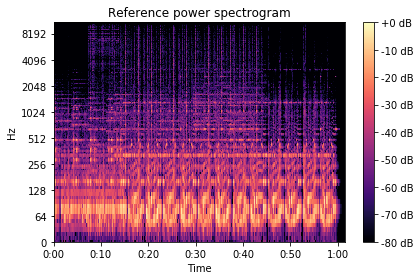

In [4]:
librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('Reference power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Calculating the spectrogram using DALI

To demonstrate DALI's Spectrogram operator we will define a DALI pipeline, whose input will be provided externally with the help of ExternalSource operator. For demonstration purposes, we can just feed the same input in every iteration, as we will be only calculating one spectrogram.

In [5]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali as dali

class SpectrogramPipeline(Pipeline):
    def __init__(self, device, batch_size, nfft, window_length, window_step, num_threads=1, device_id=0):
        super(SpectrogramPipeline, self).__init__(batch_size, num_threads, device_id)
        self.device = device
        
        self.batch_data = []
        y, sr = librosa.load(librosa.util.example_audio_file())
        for _ in range(batch_size):
            self.batch_data.append(np.array(y, dtype=np.float32))
        
        self.external_source = ops.ExternalSource()
        self.spectrogram = ops.Spectrogram(device=self.device, 
                                           nfft=nfft, 
                                           window_length=window_length,
                                           window_step=window_step)

    def define_graph(self):
        self.data = self.external_source()
        out = self.data.gpu() if self.device == 'gpu' else self.data
        out = self.spectrogram(out)
        return out

    def iter_setup(self):
        self.feed_input(self.data, self.batch_data)

With the pipeline defined, we can now just build it and run it

In [6]:
pipe = SpectrogramPipeline(device='cpu', batch_size=1, nfft=n_fft, window_length=n_fft, window_step=hop_length)
pipe.build()
outputs = pipe.run()
spectrogram_dali = outputs[0].at(0)

and display it as we did with the reference implementation

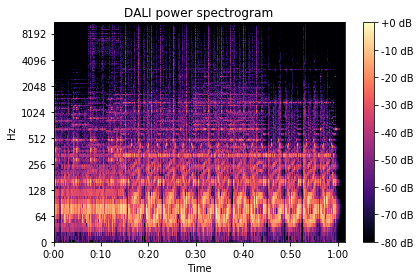

In [7]:
spectrogram_dali_db = librosa.power_to_db(spectrogram_dali, ref=np.max)
librosa.display.specshow(spectrogram_dali_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('DALI power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

As a last sanity check, we can verify that the numerical difference between the reference implementation and DALI's is insignificant

In [8]:
print("Average error: {0:.5f} dB".format(np.mean(np.abs(spectrogram_dali_db - spectrogram_librosa_db))))

Average error: 0.01145 dB


## Mel spectrogram

The mel scale is a non-linear transformation of frequency scale based on the perception of pitches. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as being equidistant. More information can be found here: https://en.wikipedia.org/wiki/Mel_scale.

In machine learning applications involving speech and audio, we typically want to represent the power spectrogram in the mel scale domain. We do that by applying a bank of overlapping triangular filters that compute the energy of the spectrum in each band.

Typically, we want the mel spectrogram represented in decibels. We can calculate a mel spectrogram in decibels by using the following DALI pipeline. 

In [9]:
class MelSpectrogramPipeline(Pipeline):
    def __init__(self, device, batch_size, nfft, window_length, window_step, num_threads=1, device_id=0):
        super(MelSpectrogramPipeline, self).__init__(batch_size, num_threads, device_id)
        self.device = device
        
        self.batch_data = []
        y, sr = librosa.load(librosa.util.example_audio_file())
        for _ in range(batch_size):
            self.batch_data.append(np.array(y, dtype=np.float32))
        
        self.external_source = ops.ExternalSource()
        self.spectrogram = ops.Spectrogram(device=self.device, 
                                           nfft=nfft, 
                                           window_length=window_length,
                                           window_step=window_step)
        
        self.mel_fbank = ops.MelFilterBank(device=self.device,
                                           sample_rate=sr,
                                           nfilter = 128,
                                           freq_high = 8000.0)
        
        self.dB = ops.ToDecibels(device=self.device, 
                                 multiplier = 10.0,
                                 cutoff_db = -80)

    def define_graph(self):
        self.data = self.external_source()
        out = self.data.gpu() if self.device == 'gpu' else self.data
        out = self.spectrogram(out)
        out = self.mel_fbank(out)
        out = self.dB(out)
        return out

    def iter_setup(self):
        self.feed_input(self.data, self.batch_data)

In [10]:
pipe = MelSpectrogramPipeline(device='cpu', batch_size=1, nfft=n_fft, window_length=n_fft, window_step=hop_length)
pipe.build()
outputs = pipe.run()
mel_spectrogram_dali_db = outputs[0].at(0)

We can now verify that it produces the same result as Librosa

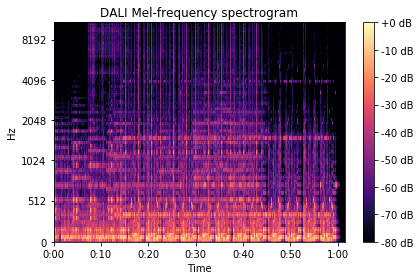

In [11]:
librosa.display.specshow(mel_spectrogram_dali_db, sr=sr, y_axis='mel', x_axis='time', hop_length=hop_length)
plt.title('DALI Mel-frequency spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [12]:
mel_spectrogram_librosa = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_librosa_db = librosa.power_to_db(mel_spectrogram_librosa, ref=np.max)
print("Average error: {0:.5f} dB".format(np.mean(np.abs(mel_spectrogram_dali_db - mel_spectrogram_librosa_db))))

Average error: 0.01046 dB
